In [1]:
# Plotting Libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as spy
sns.set_style("whitegrid")

# Pyswmm engine with ICC 
from pyswmm_lite import Env

# Bayesian Optimization
import numpy as np
from GPyOpt.methods import BayesianOptimization
import tslearn.metrics as ts
import copy
# Nodes as List
NODES_LIS = {'93-49743' : 'OR39',
             '93-49868' : 'OR34',
             '93-49919' : 'OR44',
             '93-49921' : 'OR45',
             '93-50074' : 'OR38',
             '93-50076' : 'OR46',
             '93-50077' : 'OR48',
             '93-50081' : 'OR47',
             '93-50225' : 'OR36',
             '93-90357' : 'OR43',
             '93-90358' : 'OR35'}


def run_swmm(valve_set1, valve_set2, valve_set3, valve_set4):
    env = Env("./aa_0360min_025yr.inp")

    data = {}
    data["f1"] = []
    data["f2"] = []
    data["f3"] = []
    data["f4"] = []
    data["overflow1"]  = []
    data["overflow2"]  = []
    data["overflow3"]  = []
    data["overflow4"]  = []
    done = False
    for i in range(0, 35000):
        # set the gate_position 
        env.set_gate(NODES_LIS["93-50077"], valve_set1)
        env.set_gate(NODES_LIS["93-50076"], valve_set2)
        env.set_gate(NODES_LIS["93-50081"], valve_set3)
        env.set_gate(NODES_LIS["93-49921"], valve_set4)
        
        # record_data
        data["f1"].append(env.flow(NODES_LIS["93-50077"]))
        data["f2"].append(env.flow(NODES_LIS["93-50076"]))
        data["f4"].append(env.flow(NODES_LIS["93-49921"]))
        data["f3"].append(env.flow(NODES_LIS["93-50081"]))
        
        data["overflow1"].append(env.sim._model.getNodeResult("93-50077", 4))
        data["overflow2"].append(env.sim._model.getNodeResult("93-50076", 4))
        data["overflow4"].append(env.sim._model.getNodeResult("93-49921", 4))
        data["overflow3"].append(env.sim._model.getNodeResult("93-50081", 4))
        
        # step through simulation
        done = env.step()
        
    overflows = {}
    overflows["o1"] = sum(data["overflow1"])
    overflows["o2"] = sum(data["overflow2"])
    overflows["o3"] = sum(data["overflow3"])
    overflows["o4"] = sum(data["overflow4"])
    
    env.sim._model.swmm_end()
    env.sim._model.swmm_close()
    return data, overflows

# Plot the uncontrolled reponse 
un_data, un_overflow = run_swmm(1.0, 1.0, 1.0, 1.0)

downstream_target1 = 0.6 * np.asarray(copy.deepcopy(un_data["f1"]))
#downstream_target1[downstream_target1 > 4.5] = 4.5
downstream_target1d =  spy.decimate(downstream_target1, 50)

downstream_target4 = 0.6 * np.asarray(copy.deepcopy(un_data["f4"]))
downstream_target4d =  spy.decimate(downstream_target4, 50)



def fc(x):
    data, overflow  = run_swmm(x[0][0], x[0][1], x[0][2], x[0][3])
    pred_flow1 = np.asarray(data["f1"])
    pred_flow4 = np.asarray(data["f4"])

    pred_flow1 =  spy.decimate(pred_flow1, 50)
    pred_flow4 =  spy.decimate(pred_flow4, 50)


    path, distance1 = ts.dtw_path(downstream_target1d,
            pred_flow1,
            global_constraint="sakoe_chiba",
            sakoe_chiba_radius=1)

    path, distance2 = ts.dtw_path(downstream_target4d,
            pred_flow4,
            global_constraint="sakoe_chiba",
            sakoe_chiba_radius=1)

    # sum of the outflows
    d = 0.0
    for i in overflow.keys():
        d += overflow[i]
    loss = distance1 + distance2 + (d)*10.0
    print("Distance : {0}, Overflow : {1}".format(distance1 + distance2, d))
    print("Valve ",x)
    return loss

# Define gpopt
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.0, 1.0)},
          {'name': 'var_2', 'type': 'continuous', 'domain': (0.0, 1.0)},
          {'name': 'var_3', 'type': 'continuous', 'domain': (0.0, 1.0)},
          {'name': 'var_4', 'type': 'continuous', 'domain': (0.0, 1.0)}]

# --- Solve your problem
myBopt = BayesianOptimization(f=fc,
        domain=domain,
        model_type = 'GP',
        acquisition_type='EI',
        exact_feval = True,
        acquisition_weight = 4)

myBopt.run_optimization(max_iter=50)

c_data, c_overflow = run_swmm(myBopt.x_opt[0], myBopt.x_opt[1], myBopt.x_opt[2], myBopt.x_opt[3])


plt.show()


Distance : 81.84148471778225, Overflow : 54445.04133620723
Valve  [[0.95633505 0.58907853 0.04790937 0.83527174]]
Distance : 100.97158711170545, Overflow : 89119.44993856468
Valve  [[0.14596487 0.57885652 0.02138816 0.43435286]]
Distance : 106.34995048574163, Overflow : 0.0
Valve  [[0.70737825 0.88308304 0.84453437 0.70102831]]
Distance : 104.10423131499756, Overflow : 0.0
Valve  [[0.40604572 0.94335532 0.49388849 0.6110214 ]]
Distance : 64.4994425157288, Overflow : 0.0
Valve  [[0.21776393 0.15200829 0.14543839 0.65365698]]
Distance : 59.920377041182476, Overflow : 0.0
Valve  [[0.26919961 0.15568289 0.17111615 0.65724896]]
Distance : 104.5303139239407, Overflow : 0.0
Valve  [[0.503065   0.98942855 0.71215244 0.65683628]]
Distance : 128.1794504306768, Overflow : 0.0
Valve  [[0.1765545  0.         0.25037507 0.80789485]]
Distance : 88.93525166181334, Overflow : 0.0
Valve  [[0.39086621 0.62506868 0.81228408 0.77910778]]
Distance : 119.96620254479825, Overflow : 0.0
Valve  [[0.53169099 0.6

<Figure size 640x480 with 4 Axes>

<IPython.core.display.Javascript object>


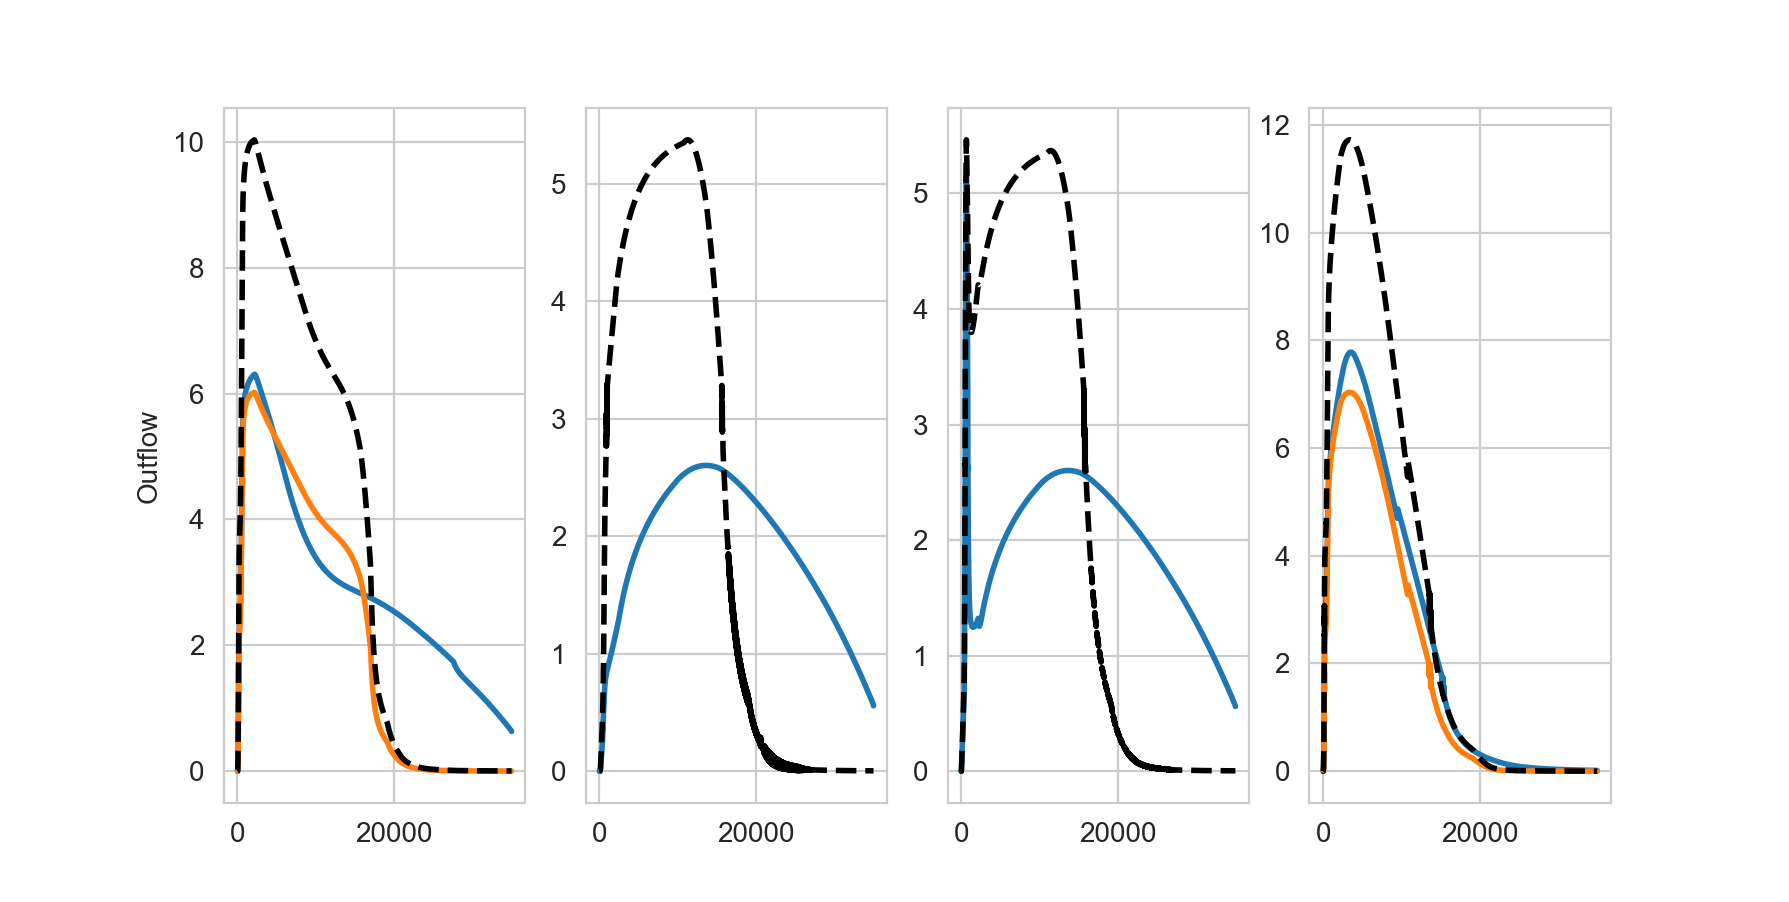

In [3]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {}

plt.subplot(1, 4, 1)
plt.plot(c_data["f1"], label = "controlled Flow",   linewidth=2.0)
plt.plot(downstream_target1, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f1"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow")

plt.subplot(1, 4, 2)
plt.plot(c_data["f2"], label = "controlled Flow",   linewidth=2.0)
plt.plot(un_data["f2"], "k--", label = "uncontrolled flow", linewidth=2.0)

plt.subplot(1, 4, 3)
plt.plot(c_data["f3"], label = "controlled Flow",   linewidth=2.0)
plt.plot(un_data["f3"], "k--", label = "uncontrolled flow", linewidth=2.0)

plt.subplot(1, 4, 4)
plt.plot(c_data["f4"], label = "controlled Flow",   linewidth=2.0)
plt.plot(downstream_target4, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f4"], "k--", label = "uncontrolled flow", linewidth=2.0)

